<a href="https://colab.research.google.com/github/ysau/PIML/blob/main/one_dimensional_harmonics_oscillator_forward_problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1D Harmonics Oscillator: Forward Problem

## Problem Statement
A mass on spring can be described by the Ordinary Differential Equation (ODE)

$$
m \dfrac{d^2 x}{d t^2} + \mu \dfrac{d x}{d t} + kx = 0~,
$$
with the initial conditions
$$
x(0) = 1~~,~~\dfrac{d x}{d t} = 0~.
$$

We are going to train a neural network NN to approximate the solution of the ODE

$$
N\!N(t;\theta) \approx u(t)~,
$$

with the loss function L

$$
L(\theta)= (N\!N(0;\theta) - 1)^2 + \lambda_1 \left(\frac{d N\!N}{dt}(0;\theta) - 0\right)^2 + \frac{\lambda_2}{N} \sum^{N}_{i} \left( \left[ m\frac{d^2}{dt^2} + \mu \frac{d}{dt} + k \right] N\!N(t_{i};\theta)  \right)^2 + \frac{\lambda}{M} \sum^{M}_{j} \left( N\!N(t_{j};\theta) - u_{\mathrm{obs}}(t_{j}) \right)^2
$$

The first two terms are the boundary conditions, the third term is the Physics loss, and the last term is the data loss

In [1]:
#@title Setup Codes
from PIL import Image as PILImage
from IPython.display import display, Image as DisplayImage

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from enum import Enum, auto

# Problem Constants
# Physics constants
DELTA = 2
W0 = 20
X_MIN = 0
X_MAX = 1
# Training constants
NUM_TRAIN_POINTS = 30
NUM_TRAIN_STEPS = 50000
LEARNING_RATE = 1e-4
PHYSICS_SCLAE = 1e-4
LOG_EVERY = 150

def oscillator(d, w0, x):
    """Defines the analytical solution to the 1D underdamped harmonic oscillator problem.
    Equations taken from: https://beltoforion.de/en/harmonic_oscillator/"""
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*x)
    sin = torch.sin(phi+w*x)
    exp = torch.exp(-d*x)
    y  = exp*2*A*cos
    return y

class FCN(nn.Module):
    "Defines a connected network"

    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

def generate_train_data(delta, w0, num_points, x_min=0, x_max=1):
  x = x = torch.linspace(x_min,x_max,num_points).view(-1,1).detach().requires_grad_(True)
  y = oscillator(delta, w0, x).view(-1,1).clone().detach().requires_grad_(True)
  return x, y

def plot_result(x,y,x_data,y_data,yh,xp=None,step=0,title="PINN Results"):
    "Pretty plot training results"
    plt.figure(figsize=(8,4))
    plt.plot(x,y, color="grey", linewidth=2, alpha=0.8, label="Exact solution")
    plt.plot(x,yh, color="tab:blue", linewidth=4, alpha=0.8, label="Neural network prediction")
    plt.scatter(x_data, y_data, s=60, color="tab:orange", alpha=0.4, label='Training data')
    if xp is not None:
        plt.scatter(xp, -0*torch.ones_like(xp), s=60, color="tab:green", alpha=0.4,
                    label='Physics loss training locations')
    l = plt.legend(loc=(1.01,0.34), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    plt.xlim(-0.05, 1.05)
    plt.ylim(-1.1, 1.1)
    plt.text(1.065,0.7,"Training step: %step"%(step+1),fontsize="xx-large",color="k")
    plt.axis("off")

def save_gif_PIL(outfile, files, fps=5, loop=0):
    "Helper function for saving GIFs"
    imgs = [PILImage.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)


class TrainType(Enum):
    ALL = auto()
    DATA = auto()
    PHYSICS = auto()

def train(delta, w0, num_train_points, num_train_steps, train_type):
  if train_type == TrainType.PHYSICS:
    # Using the first train point as boundary conditions
    x_train, y_train = generate_train_data(delta, w0, num_points=1, x_min=X_MIN, x_max=X_MAX / 2)
    # Note that y coordinate is discarded
    x_physics, _ = generate_train_data(delta, w0, num_points=num_train_points, x_min=X_MIN, x_max=X_MAX)


  # Full-domain resolution for plotting
  x_ref = torch.linspace(0,1,1000).view(-1,1)
  y_ref = oscillator(delta, w0, x_ref)

  torch.manual_seed(123)
  model = FCN(1,1,32,3)
  optimizer = torch.optim.Adam(model.parameters(),lr=LEARNING_RATE)

  plot_files = []

  for step in range(1, num_train_steps + 1):
    optimizer.zero_grad()

    # compute the "boundary loss"
    y_hat_boundary = model(x_train)
    boundary_value_loss = (y_hat_boundary - y_train).pow(2).mean()
    dy_dx_boundary = torch.autograd.grad(y_hat_boundary.sum(), x_train, create_graph=True)[0]
    boundary_loss = boundary_value_loss + dy_dx_boundary.pow(2).mean()

    # compute the "physics loss"
    y_hat_phys = model(x_physics)
    dy_dx_phys  = torch.autograd.grad(y_hat_phys.sum(), x_physics, create_graph=True)[0]
    d2y_d2x_phys = torch.autograd.grad(dy_dx_phys.sum(),  x_physics,  create_graph=True)[0]
    mu, k = 2 * delta, w0**2
    residual = d2y_d2x_phys + mu * dy_dx_phys + k * y_hat_phys
    physics_loss = PHYSICS_SCLAE * residual.pow(2).mean()

    # backpropagate joint loss
    loss = physics_loss + boundary_loss
    loss.backward()
    optimizer.step()


    # plot the result as training progresses
    if step % LOG_EVERY == 0:
        with torch.no_grad():
          y_hat_ref = model(x_ref)
          if train_type == TrainType.PHYSICS:
            plot_title = "Physics Loss Only"
            fname = f"pinn_physics_{step:08d}.png"
          elif train_type == TrainType.DATA:
            plot_title = "Data Loss Only"
            fname = f"pinn_data_{step:08d}.png"
          else:
            plot_title = "Physics + Data Loss"
            fname = f"pinn_physics_data_{step:08d}.png"
          plot_result(x_ref,y_ref,x_train.detach()[:num_train_points],y_train.detach()[:num_train_points], y_hat_ref.detach(), x_physics.detach(), step,
                      title=plot_title)
          plt.savefig(fname, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
          plot_files.append(fname)
          if (step+1) % 6000 == 0: plt.show()
          else: plt.close("all")
  try:
      if train_type == TrainType.PHYSICS:
          fname = "pinn_physics.gif"
      save_gif_PIL(fname, plot_files, fps=20, loop=0)
      display(DisplayImage(filename=fname))
  except Exception as e:
      print(f"GIF creation skipped: {e}")






def check_gpu():
  if torch.cuda.is_available():
    print(f"{torch.cuda.device_count()} GPU(s) are available")
  else:
    print("GPU is not available. Using CPU")

In [2]:
#@title Check Compute Resource
check_gpu()

1 GPU(s) are available


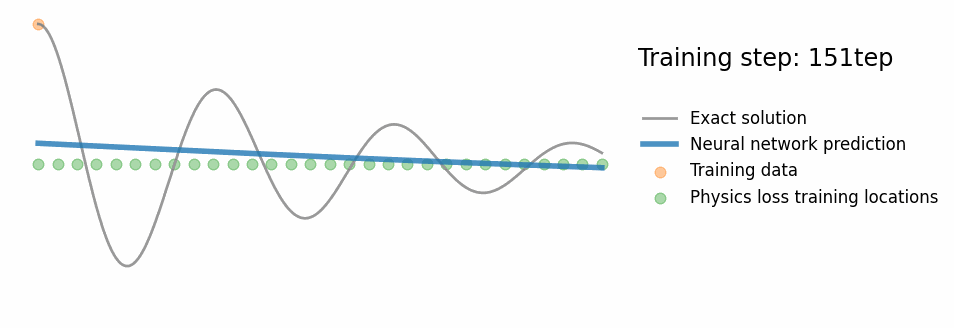

In [3]:
#@title Training using Physics Loss Only
train(DELTA, W0, NUM_TRAIN_POINTS, NUM_TRAIN_STEPS, TrainType.PHYSICS)

In [ ]:
#@title Training using Data Loss Only
train(DELTA, W0, NUM_TRAIN_POINTS, NUM_TRAIN_STEPS, TrainType.DATA)

In [ ]:
#@title Training using Physics and Data Loss
train(DELTA, W0, NUM_TRAIN_POINTS, NUM_TRAIN_STEPS, TrainType.ALL)

In [4]:
#@title [Optional] Install Black Code Formatter - Require connection to Google Drive
!pip install black[jupyter] --quiet
from google.colab import drive

drive.mount("/content/drive")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 80.0 MB/s eta 0:00:00
Mounted at /content/drive


In [5]:
#@title Format using Black
!black /content/drive/MyDrive/'Colab Notebooks'/'one_dimensional_harmonics_oscillator_forward_problem.ipynb'

All done! ✨ 🍰 ✨
1 file left unchanged.


### Disclaimers
This notebook was modified based on


1.   https://github.com/benmoseley/harmonic-oscillator-pinn
2.   https://github.com/benmoseley/FBPINNs

My specific contributions include


1.   Separate the effects of Physics loss vs data loss
2.   Incorporate boundary loss
3.   How to improve training using Physics loss only via scheduled training



